### A/B testing

A online store called shoeFly.com is performing an A/B test. They are testing two adds, and they want to know how different versions of ad are behaving on different websites. Let's explore the data together!

In [1]:
import pandas as pd

ad_clicks = pd.read_csv("https://raw.githubusercontent.com/Frankkao813/DataAnalysis/main/Dataset/ad_clicks.csv")
ad_clicks.head()

,user_id,utm_source,day,ad_click_timestamp,experimental_group
0,008b7c6c-7272-471e-b90e-930d548bd8d7,google,6 - Saturday,7:18,A
1,009abb94-5e14-4b6c-bb1c-4f4df7aa7557,facebook,7 - Sunday,NaN,B
2,00f5d532-ed58-4570-b6d2-768df5f41aed,twitter,2 - Tuesday,NaN,A
3,011adc64-0f44-4fd9-a0bb-f1506d2ad439,google,2 - Tuesday,NaN,B
4,012137e6-7ae7-4649-af68-205b4702169c,facebook,7 - Sunday,NaN,B


### Q: Which platform give you the most views?
We can use `groupby()`on utm_source to obtain the answer. By the result, people go to the shoefly website using facebook most often.   

In [2]:
utm_view = ad_clicks.groupby("utm_source").user_id.count().reset_index()
utm_view_sort = utm_view.sort_values("user_id",ascending = False)
utm_view_sort.rename(columns = {"user_id":"counts"}, inplace = True)
print(utm_view_sort)

  utm_source  counts
2     google     680
1   facebook     504
0      email     255
3    twitter     215


### Q: How many people actually click the link to the website? 

If the user actually click an ad, there will be value in the ad_click_timestamp column instead of Nan. 

Steps:
* add a `is_click` column to indicate whether the people seeing the ad actually clicks the ad.
* use pandas groupby() and pivot() functions to answer the question



In [3]:
ad_clicks["is_click"] = ad_clicks.ad_click_timestamp.apply(lambda content: True if content == content else False)

click_by_source = ad_clicks.groupby(["utm_source","is_click"]).user_id.count().reset_index()
click_by_source_pivot = click_by_source.pivot(
    columns = "is_click",
    index = "utm_source",
    values = "user_id"
).reset_index()
print(click_by_source_pivot)

is_click utm_source  False  True
0             email    175    80
1          facebook    324   180
2            google    441   239
3           twitter    149    66


### Q: Is there are greater percentage of user click on Ad A or Ad B?

* use `df.groupby()` on `experimental_group` and `is_click` column.
* After using pivot(), we cam do some math calculations.

However, before we make any inference on the percentage, we should check whether there are the same bumber of people seeing the ad. By the `total_people` column, the people seeing the ad are approximately the same.


In [5]:
show_AB_clicks = ad_clicks.groupby(["experimental_group","is_click"]).user_id.count().reset_index()
show_AB_clicks_pivot = show_AB_clicks.pivot(
    columns = "is_click",
    index = "experimental_group",
    values = "user_id"
).reset_index()
show_AB_clicks_pivot["total_people"] = show_AB_clicks_pivot.apply(lambda row: row[False] + row[True], axis = 1)
show_AB_clicks_pivot["percentage_see"] = show_AB_clicks_pivot[True]/(show_AB_clicks_pivot[False]+show_AB_clicks_pivot[True])
print(show_AB_clicks_pivot)

is_click experimental_group  False  True  total_people  percentage_see
0                         A    517   310           827        0.374849
1                         B    572   255           827        0.308343


### Q: Does the clicks change by day of the week?

steps:
* We first create a_clicks and b_clicks dataframe
* For each dataframe, calculate the percent of users who clicked the ad by day
* compare the result

In [6]:
a_clicks = ad_clicks[ad_clicks["experimental_group"] == "A"]
b_clicks = ad_clicks[ad_clicks.experimental_group == "B"]

a_clicks_by_day = a_clicks.groupby(["is_click","day"]).user_id.count().reset_index()
b_clicks_by_day = b_clicks.groupby(["is_click","day"]).user_id.count().reset_index()

# pivot table
a_clicks_by_day_pivot = a_clicks_by_day.pivot(
  columns = "is_click",
  index = "day",
  values = "user_id"
)

b_clicks_by_day_pivot = b_clicks_by_day.pivot(
  columns = "is_click",
  index = "day",
  values = "user_id"
)

a_clicks_by_day_pivot["percentage"] = a_clicks_by_day_pivot[True]/(a_clicks_by_day_pivot[True] + a_clicks_by_day_pivot[False])
print(a_clicks_by_day_pivot)



is_click       False  True  percentage
day                                   
1 - Monday        70    43    0.380531
2 - Tuesday       76    43    0.361345
3 - Wednesday     86    38    0.306452
4 - Thursday      69    47    0.405172
5 - Friday        77    51    0.398438
6 - Saturday      73    45    0.381356
7 - Sunday        66    43    0.394495


In [7]:
b_clicks_by_day_pivot["percentage"] = b_clicks_by_day_pivot[True]/(b_clicks_by_day_pivot[True] + b_clicks_by_day_pivot[False])
print(b_clicks_by_day_pivot)

is_click       False  True  percentage
day                                   
1 - Monday        81    32    0.283186
2 - Tuesday       74    45    0.378151
3 - Wednesday     89    35    0.282258
4 - Thursday      87    29    0.250000
5 - Friday        90    38    0.296875
6 - Saturday      76    42    0.355932
7 - Sunday        75    34    0.311927


Having the above two pivot plot, we can do some visualization using grouped bar plot. From the result below, I would recommend A ad because the percentage of clicks is higher.


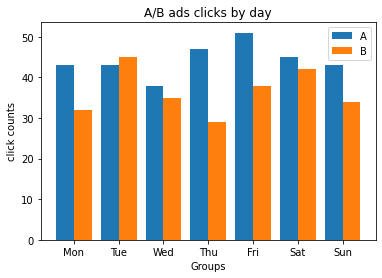

In [17]:
# draw grouped bar plot
import numpy as np
import matplotlib.pyplot as plt

X = a_clicks_by_day_pivot.index

X_new = []
for i in X:
    X_newElement = i[4:7]
    X_new.append(X_newElement)

X_axis = np.arange(len(X))
A_percentage = a_clicks_by_day_pivot[True].tolist()
B_percentage = b_clicks_by_day_pivot[True].tolist()
plt.bar(X_axis - 0.2, A_percentage, 0.4, label ="A")
plt.bar(X_axis + 0.2, B_percentage, 0.4, label ="B")

plt.xticks(X_axis, X_new)
plt.xlabel("day")
plt.ylabel("click counts")
plt.title(r"A/B ads clicks by day")
plt.legend()
plt.show()


Q: What is the composition of people clicking the A/B ads everyday?

Is there a dominant platform that the user use to click into the website? We take A as an example. The desired graph will be a stacked plot.

From the stacked plot, we can find that number of people click the ad on twitter is the least, which probably means that the ad isn't getting enough exposure. We should consider boosting advertisement on this social media.

In [21]:
#percent stacked plot
A_clicks_distribution = ad_clicks[(ad_clicks["experimental_group"] == "A") & (ad_clicks["is_click"] == True)]
A_clicks_distribution.head()


,user_id,utm_source,day,ad_click_timestamp,experimental_group,is_click
0,008b7c6c-7272-471e-b90e-930d548bd8d7,google,6 - Saturday,7:18,A,True
8,018cea61-19ea-4119-895b-1a4309ccb148,email,1 - Monday,18:33,A,True
18,041deef8-b242-4114-afd0-e584784ec9f0,google,3 - Wednesday,10:54,A,True
21,0441f866-dd3f-422a-a36a-cdc2f034e6ef,google,7 - Sunday,11:16,A,True
23,0482e1ab-b513-4bfb-9914-9fb5ab41c915,twitter,6 - Saturday,1:20,A,True


In [22]:
B_clicks_distribution = ad_clicks[(ad_clicks["experimental_group"] == "B") & (ad_clicks["is_click"] == True)]
B_clicks_distribution.head()


,user_id,utm_source,day,ad_click_timestamp,experimental_group,is_click
9,01a210c3-fde0-4e6f-8efd-4f0e38730ae6,email,2 - Tuesday,15:21,B,True
11,01ae0361-7d17-4760-a2c8-23977a46fb78,facebook,4 - Thursday,7:11,B,True
26,05aec9ea-92c1-4ffc-84b5-c3864dd307e4,facebook,5 - Friday,8:46,B,True
45,083e3bbf-abe4-418c-8b17-7ac77b436ab1,google,2 - Tuesday,3:21,B,True
71,0dd20a2e-cb05-46c7-b14a-2e4a54d3dca3,twitter,3 - Wednesday,10:24,B,True


In [44]:
A_clicks_distribution_day = A_clicks_distribution.groupby(["utm_source", "day"]).user_id.count().reset_index()
B_clicks_distribution_day = B_clicks_distribution.groupby(["utm_source", "day"]).user_id.count().reset_index()
A_clicks_distribution_day_pivot = A_clicks_distribution_day.pivot(
    columns = "day",
    index = "utm_source",
    values= "user_id"
).reset_index()
A_clicks_distribution_day_pivot["total"] = A_clicks_distribution_day_pivot.sum(axis =1)

A_clicks_distribution_day_pivot

day,utm_source,1 - Monday,2 - Tuesday,3 - Wednesday,4 - Thursday,5 - Friday,6 - Saturday,7 - Sunday,total
0,email,10,7,7,2,4,5,6,41
1,facebook,15,13,12,13,14,14,13,94
2,google,17,19,13,25,26,19,18,137
3,twitter,1,4,6,7,7,7,6,38


[array([10,  7,  7,  2,  4,  5,  6]), array([15, 13, 12, 13, 14, 14, 13]), array([17, 19, 13, 25, 26, 19, 18]), array([1, 4, 6, 7, 7, 7, 6])]


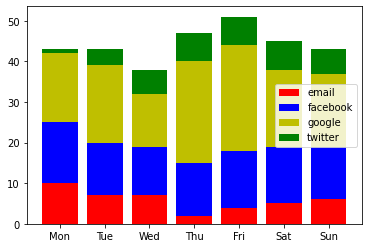

In [43]:
import matplotlib.pyplot as plt
import numpy as np
matrix = []
for i in range(4):
    utm_day = np.array(A_clicks_distribution_day_pivot.iloc[i,1:].tolist())
    matrix.append(utm_day)

#plot bars in stack
plt.bar(X_new, matrix[0], color = 'r')
plt.bar(X_new, matrix[1], bottom= matrix[0], color="b")
plt.bar(X_new, matrix[2], bottom = matrix[0]+matrix[1], color = "y")
plt.bar(X_new, matrix[3], bottom=matrix[0]+matrix[1]+matrix[2], color = "g")
plt.legend(["email", "facebook", "google", "twitter"])